In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.load("npy/X.npy")
Y = np.load("npy/Y.npy")

In [3]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=42
)

Using 100x100 to get better performance on local machine

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Define the base model (MobileNetV2)
baseModel = MobileNetV2(
    weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3))
)

# Build the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# Place the head on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(
    loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"]
)

print("Model compiled successfully!")

C:\Users\Siddharth\AppData\Local\Temp\ipykernel_73648\1337378793.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(100, 100, 3)))


Model compiled successfully!


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Mdoel training params
EPOCHS = 50
BS = 32

In [6]:
history = model.fit(
    trainX,
    trainY,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    batch_size=BS,
    callbacks=[early_stop],
)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.7739 - loss: 0.5519 - val_accuracy: 0.8533 - val_loss: 0.3380
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8546 - loss: 0.3373 - val_accuracy: 0.8594 - val_loss: 0.3250
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.8639 - loss: 0.3218 - val_accuracy: 0.8625 - val_loss: 0.3185
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.8750 - loss: 0.2890 - val_accuracy: 0.8649 - val_loss: 0.3051
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.8791 - loss: 0.2769 - val_accuracy: 0.8649 - val_loss: 0.2973
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.8816 - loss: 0.2710 - val_accuracy: 0.8674 - val_loss: 0.2943
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.8926 - loss: 0.2494 - val_accuracy: 0.8667 - val_loss: 0.2908
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.8875 - loss: 0.2532 -

Future Scope - Can try data augmentation as well

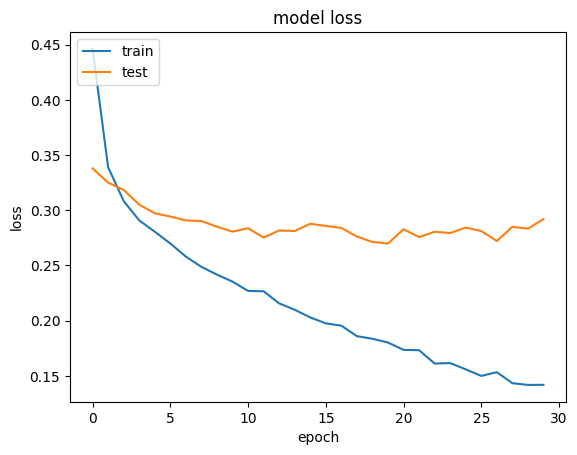

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [19]:
predictions = model.predict(testX)

for i, prediction in enumerate(predictions):
    if prediction > 0.5:
        predictions[i] = 1
    else:
        predictions[i] = 0

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step


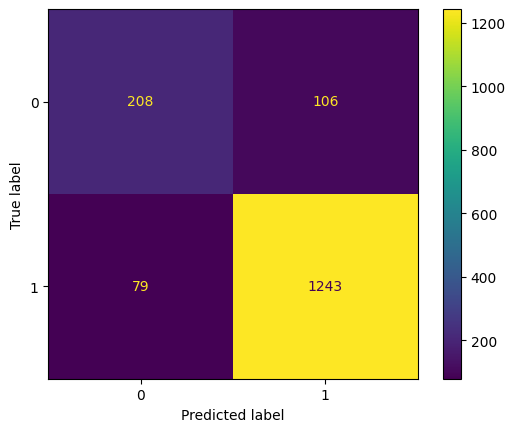

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix = ConfusionMatrixDisplay(confusion_matrix(testY, predictions))
matrix.plot()
plt.show()

In [8]:
# Save model
model.save("models/facemask_detector_model.keras")
print("Model trained and saved!")

Model trained and saved!


In [9]:
with open("models/history_facemask_detector_model", "wb") as f:
    pickle.dump(history.history, f)